# 1. Business Understanding

In this project I'm going to develop a pricing algorithm for houses in the northwest county based on a past collected data of house sales. The goal is to help homeowners save time on buying and/or selling houses.

This algorithm is predictive, meaning it will help stackeholders who want to buy or sell houses can use this algorithm to predcit house prices based on home renovations.

This algorithm will be able to tell us something about the relationship between attributes of houses and their prices. It other terms it will be inferential.


# Loading the data

In [748]:
# importing the necessary libraries for this project
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from  sklearn.impute import SimpleImputer

import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(21)

%matplotlib inline

In [749]:
# loading the dataset
df = pd.read_csv('./data/kc_house_data.csv', index_col='id')
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [750]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 7129300520 to 1523300157
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21597 non-null  object 
 1   price          21597 non-null  float64
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   waterfront     19221 non-null  float64
 8   view           21534 non-null  float64
 9   condition      21597 non-null  int64  
 10  grade          21597 non-null  int64  
 11  sqft_above     21597 non-null  int64  
 12  sqft_basement  21597 non-null  object 
 13  yr_built       21597 non-null  int64  
 14  yr_renovated   17755 non-null  float64
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float

In [751]:
original_shape = df.shape 
original_shape

(21597, 20)

# 2. Data Understanding
 - Given is a a King County House Sales dataset. Which contains house attributes as well  as their prices. This is suitable for this project as we willl be using these attributes to predict the house prices.
 - The dataset has a total of 21,597 rows and 21 columns. Meaning 21,597 houses were taken as a sample and 21 of their existing attributes recorded.
 - Based on the sample given some attributes will sure help show the relationship between them and house prices.
 - The data also has some irrelevant columns which will be dropped, since they might hinder in creating a good model.


# 3. Data Preparation

The prediction target for this analysis is the proce of houses, hence will separate X and y appropiately

In [752]:
X = df.drop('price', axis=1)
y = df['price']

In [753]:
# splitting the data into a train and test sets, prior beforming any preprocesssing steps
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=50)

In [754]:
print(f"X_train is a dataframe with {X_train.shape[0]} records and {X_train.shape[1]} attributes")
print(f"y_train is a series with {y_train.shape[0]} values")
print()
print(f"X_test has {X_test.shape[0]} records")
print(f"y_test has {y_test.shape[0]} records")

X_train is a dataframe with 16197 records and 19 attributes
y_train is a series with 16197 values

X_test has 5400 records
y_test has 5400 records


## Handling Mising Values

### Functions for Missing Values

In [755]:
# function to concate a set with its target variable
def concater(X, y):
    result = pd.concat([y, X], axis = 1)
    return result

In [756]:
# function to split concated set with its target variable and convert to floors and waterfront to integers
def set_splitter(dataset):
    X = dataset.drop('price', axis=1)
    y = dataset.price
    
    return X, y

Checking for null values in the train set

In [757]:
# Concating X_train and y_train
concated_train = concater(X_train, y_train)
concated_train.isna().sum()

price               0
date                0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       1788
view               47
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     2885
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

### Dealing with yr_renovated null values

In [758]:
# Checking for the values in thr yr_renovated column
concated_train['yr_renovated'].value_counts()

0.0       12750
2014.0       52
2003.0       24
2005.0       23
2000.0       23
          ...  
1959.0        1
1945.0        1
1944.0        1
1948.0        1
1953.0        1
Name: yr_renovated, Length: 65, dtype: int64

#### For yr_renovated I will use SimpleImputer to help deal with the null values

In [759]:
#  function for dealing with null values in a given set based on the yr_renovated column
def yr_renovated(concated_set):
    # creating a dataframe which contains the yr_renovated columns
    # NB: The houses without renavations have been filtered out
    year_renovated = concated_set[concated_set['yr_renovated'] != 0][['yr_renovated']]

    # using simpleImputer to deal with the null values in the yr_renovated column
    imput = SimpleImputer(missing_values=np.nan, strategy='median')
    imput.fit(year_renovated)
    new_year_renovated = imput.transform(year_renovated).flatten()
    year_renovated['yr_renovated'] = new_year_renovated

    condition = (
        concated_set.yr_renovated != 0 &
        concated_set.yr_renovated.isna()
    )

    # reassing the variables to the yr_renovated column strictly with columns whose values are not in the 0
    concated_set.loc[condition, 'yr_renovated'] = year_renovated

    return concated_set

In [760]:
# dealing with null values in the concated_train set
concated_train = yr_renovated(concated_train)
concated_train.isna().sum()

price               0
date                0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       1788
view               47
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated        0
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

### Dealing with null values in the view column

In [763]:
# checking for the unique values in the column and their occurence
concated_train.view.value_counts()

0.0    14585
2.0      718
3.0      356
4.0      246
1.0      245
Name: view, dtype: int64

In [764]:
concated_train.waterfront.value_counts()

0.0    14297
1.0      112
Name: waterfront, dtype: int64

Since I'm not sure if the houeses missing the view data have been viewed or not or if they have a waterfront in them, I will drop them so that

## A histogram showing the distribution of the target variable (house price)

Text(0.5, 1.0, 'Distribution of house prices')

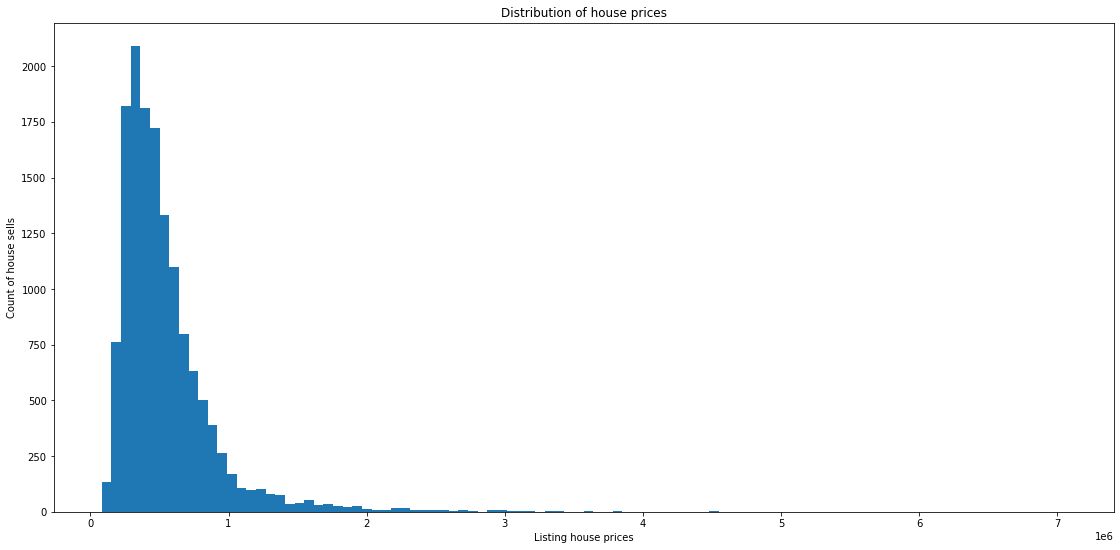

In [413]:
fig, ax = plt.subplots(figsize=(19,9))

ax.hist(y_train, bins=100)


ax.set_xlabel('Listing house prices')
ax.set_ylabel('Count of house sells')
ax.set_title('Distribution of house prices')

In [414]:
# function to check for outliers
def outliers(column):
    outliers = []
    quantile1, quantile2 = column.quantile([0.01 ,0.99])

    for i in column:
        if (i < quantile1) | (i > quantile2):
            outliers.append(i)

    return outliers


In [415]:
concated_train_ouliers = outliers(y_train)
len(concated_train_ouliers)

287

### From above we have 287 outlies in the train dataset hence will remove them so as to not affect the analysis

In [416]:
# function to remove outliers and returns the new updated dataframe
def outliers_remover(dataset, outliers):
    subset = dataset.copy()
    for i in outliers:
        row_index = subset[ subset.price == i ].index
        subset.drop(row_index, inplace=True)
    return subset

In [417]:
print(f"Number of train set records before removing outliers {concated_train.shape[0]}")
print()
concated_train = outliers_remover(concated_train, concated_train_ouliers)
print(f"Number of train set records after removing outliers {concated_train.shape[0]}")

Number of train set records before removing outliers 14409

Number of train set records after removing outliers 14109


In [418]:
# splitting into X and y using the intially created set_splitter function
X_Train, y_Train = set_splitter(concated_train)
display(len(X_Train))
len(y_Train)

14109

14109

### A histogram showing the distribution of the target variable (house price) after removing the outliers

Text(0.5, 1.0, 'Distribution of house prices')

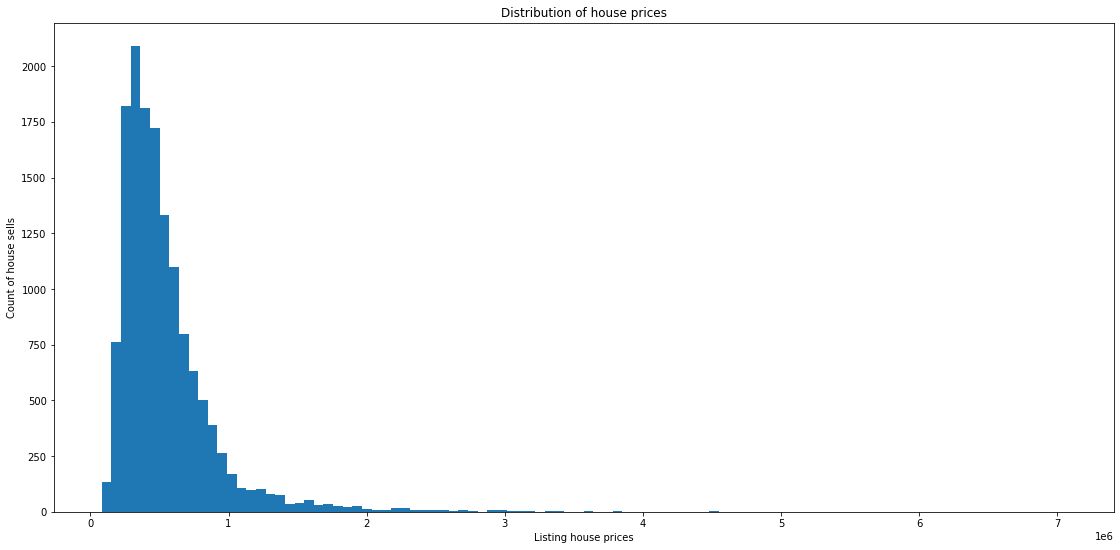

In [419]:
fig, ax = plt.subplots(figsize=(19,9))

ax.hist(y_train, bins=100)

ax.set_xlabel('Listing house prices')
ax.set_ylabel('Count of house sells')
ax.set_title('Distribution of house prices')

# 4. Modeling

### Building a heat map to show correlation between all train set attributes and their target which is the house price

<AxesSubplot:>

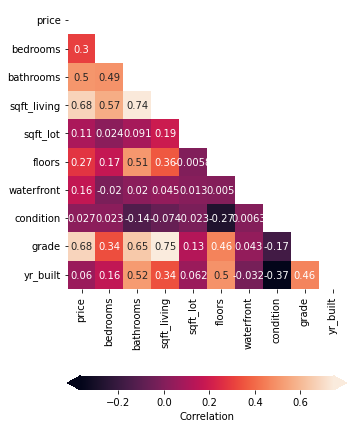

In [420]:
heatmap_x = concated_train

train_test_corr = heatmap_x.corr()
fig, ax = plt.subplots(figsize=(5, 8))

sns.heatmap(
    # Specifies the data to be plotted
    data = train_test_corr,
    # The mask means we only show half the values, instead of showing duplicates.
    mask= np.triu(np.ones_like(train_test_corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizing colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}

)

In [421]:
#  From the chart the most correlated features are
most_correlated_features = ['sqft_living', 'grade']


A scatterplot of the most_correlated_feature vs house prices

### Building a baseline model with the most correlated features

### Building a model 

In [422]:
# Function for getting coeeficients in a cross_valiate
def coeeficients(score):
    for model in score['estimator']:
        print(model.coef_)

In [423]:
# Intializing a splitter
splitter = ShuffleSplit(
    n_splits=3,
    test_size=0.25,
    random_state=20
) # perfoms a 5 seperate train-test splits 

### Baseline Model 

In [424]:
baseline_model = LinearRegression()

baseline_score = cross_validate(
    estimator=baseline_model,
    X=X_train[most_correlated_features],
    y=y_train,
    return_train_score=True,
    return_estimator=True,
    cv=splitter
)

print(f"Train Score:            {baseline_score['train_score'].mean()}")
print(f"Validation Score:       {baseline_score['test_score'].mean()}")


Train Score:            0.5343943103093689
Validation Score:       0.5379924181809541


This difference between the train score and validation score is low meaning it is a good model fit. But a 0.5 R-score in the train score reflects a model that explains half of the total variance in the data.

### Second Model

Selecting best features using RFECV

In [425]:
# investigating for multicolinearity
sm.OLS(y_train, sm.add_constant(X_train)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     3027.
Date:                Wed, 29 Jun 2022   Prob (F-statistic):               0.00
Time:                        20:36:40   Log-Likelihood:            -1.9760e+05
No. Observations:               14409   AIC:                         3.952e+05
Df Residuals:                   14399   BIC:                         3.953e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        6.651e+06   1.59e+05     41.884      0.000    6.34e+06    6.96e+06
bedrooms    -4.137e+04   2489.414    -16.620      0.000   -4.63e+04   -3.65e+04
bathrooms    4.891e+04   4227.618     11.570      0.000    4.06e+04    5.72e+04
sqft_living   177.2148      4.004     44.257      0.000     169.366     185.063
sqft_lot       -0.3152      0.049     -6.394      0.000      -0.412      -0.219
floors       2.027e+04   4267.489      4.749      0.000    1.19e+04    2.86e+04
waterfront   8.091e+05    2.1e+04     38.456      0.000    7.68e+05     8.5e+05
condition    1.902e+04   3050.257      6.236      0.000     1.3e+04     2.5e+04
grade        1.296e+05   2621.229     49.426      0.000    1.24e+05    1.35e+05
yr_built    -3821.4163     81.637    -46.810      0.000   -3981.436   -3661.397
==============================================================================
Omnibus:                     9545.132   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           396649.119
Skew:                           2.629   Prob(JB):                         0.00
Kurtosis:                      28.160   Cond. No.                     3.56e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.56e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [426]:
# using REFCV
X_train_REFECV = StandardScaler().fit_transform(X_train)

model_for_REFECV = LinearRegression()

# Intitate and fit the selector
selector = RFECV(model_for_REFECV, cv=splitter)
selector.fit(X_train_REFECV, y_train)

# Print the results
print("Was the column selected")
for index, col in enumerate(X_train.columns):
    print(f"{col}: {selector.support_[index]}")

Was the column selected
bedrooms: True
bathrooms: True
sqft_living: True
sqft_lot: True
floors: True
waterfront: True
condition: True
grade: True
yr_built: True


In the next model I will select all the attributes since their p-alue are low and also we have a better R2 score than compared to the other model.

In [427]:
second_model = LinearRegression()

second_score = cross_validate(
    estimator=second_model,
    X=X_train,
    y=y_train,
    return_train_score=True,
    return_estimator=True,
    cv=splitter
)

print(f"Train Score:            {second_score['train_score'].mean()}")
print(f"Validation Score:       {second_score['test_score'].mean()}")


Train Score:            0.6520227982487956
Validation Score:       0.6596111805252182


Building a complex model using PolynomialFeatures to see if we get a better score.

In [428]:
poly_2 = PolynomialFeatures(2)
X_train_poly=pd.DataFrame(poly_2.fit_transform(X_train))

In [429]:
third_model = LinearRegression()

third_score = cross_validate(
    estimator=third_model,
    X=X_train_poly,
    y=y_train,
    return_train_score=True,
    return_estimator=True,
    cv=splitter
)

print(f"Train Score:            {third_score['train_score'].mean()}")
print(f"Validation Score:       {third_score['test_score'].mean()}")


Train Score:            0.7245026208875333
Validation Score:       0.7177177036203618


using a more complex PolynomialFeature

In [430]:
poly_3 = PolynomialFeatures(3)
X_train_poly_3=pd.DataFrame(poly_3.fit_transform(X_train))

In [431]:
third_model = LinearRegression()

third_score = cross_validate(
    estimator=third_model,
    X=X_train_poly_3,
    y=y_train,
    return_train_score=True,
    return_estimator=True,
    cv=splitter
)

print(f"Train Score:            {third_score['train_score'].mean()}")
print(f"Validation Score:       {third_score['test_score'].mean()}")


Train Score:            0.734082515544748
Validation Score:       0.7075666469065752


Both the polnomial models have a high trainig score but a low validation score this means that the models ore overfitting hence not good models to use to predict with. test

From above all models are selected hence we will go with the second model as our best model. Since the difference between the test score and validation score is little

In [432]:
best_model = second_model # it scored better results in the validation score with a R2 of approximately 0.7

print()
X_Train_columns = list(X_train.columns)
print("Attribute:\t\tCoeffiecient")

count = 0
for i in range(len(X_Train_columns)):
    for model in second_score['estimator']:
        i_coeffient = []
        i_coeffient.append(model.coef_[i])
    
    print(f"{X_Train_columns[i]}:\t\t{np.mean(i_coeffient)}")


Attribute:		Coeffiecient
bedrooms:		-38100.86644791156
bathrooms:		43389.9212691553
sqft_living:		174.71728112881829
sqft_lot:		-0.2660810435190797
floors:		24446.509474992097
waterfront:		801467.388981025
condition:		19188.74429698629
grade:		129010.6263679609
yr_built:		-3807.2433957980525


In [433]:
best_model.fit(X_train, y_train)
best_model.score(X_train,y_train)

0.6542222974812659

In [434]:
best_model.score(X_test, y_test)

0.6335928436393556

## Above are the R-2, below I will also calculate the RMSE